In [2]:
import os

os.chdir("/home/kaborg15/FREja/")

In [3]:
import pandas as pd

PKL_DATA_FOLDER = "Pickled_Data/Embeddings_final", "Pickled_Data/Embeddings_float16"
LOAD_MODELS = [
    "resnet50_V1_Config.pkl",
    #"resnet50_V2_Config.pkl",
    #"resnet152_V1_Config.pkl",
    "ViT_H_14_E2E_Config.pkl"
]

embeddings_dict = {}
for model in LOAD_MODELS:
    for data_folder in PKL_DATA_FOLDER:
        if model not in os.listdir(data_folder):
            continue
        model_path = os.path.join(data_folder, model)
        break
    else:
        raise Exception(f"Could not find {model} in any of the data folders!")
    embeddings_dict[model] = pd.read_pickle(model_path)
    print(f"Loaded {model} from {model_path}...")

Loaded resnet50_V1_Config.pkl from Pickled_Data/Embeddings_final/resnet50_V1_Config.pkl...
Loaded ViT_H_14_E2E_Config.pkl from Pickled_Data/Embeddings_final/ViT_H_14_E2E_Config.pkl...


In [20]:
import numpy as np
embeddings_df = embeddings_dict["ViT_H_14_E2E_Config.pkl"]
#embeddings_df = embeddings_dict["resnet50_V1_Config.pkl"]
np_embeddings = np.vstack([embed.numpy() for i, embed in enumerate(embeddings_df["embeddings"])])
np_embeddings.shape

(18060, 1000)

In [21]:
import matplotlib.pyplot as plt
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, verbose=1)
tsne_embeds = tsne.fit_transform(np_embeddings)
tsne_embeds.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18060 samples in 0.196s...
[t-SNE] Computed neighbors for 18060 samples in 111.798s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18060
[t-SNE] Computed conditional probabilities for sample 2000 / 18060
[t-SNE] Computed conditional probabilities for sample 3000 / 18060
[t-SNE] Computed conditional probabilities for sample 4000 / 18060
[t-SNE] Computed conditional probabilities for sample 5000 / 18060
[t-SNE] Computed conditional probabilities for sample 6000 / 18060
[t-SNE] Computed conditional probabilities for sample 7000 / 18060
[t-SNE] Computed conditional probabilities for sample 8000 / 18060
[t-SNE] Computed conditional probabilities for sample 9000 / 18060
[t-SNE] Computed conditional probabilities for sample 10000 / 18060
[t-SNE] Computed conditional probabilities for sample 11000 / 18060
[t-SNE] Computed conditional probabilities for sample 12000 / 18060
[t-SNE] Computed conditional probabilities for s

(18060, 2)

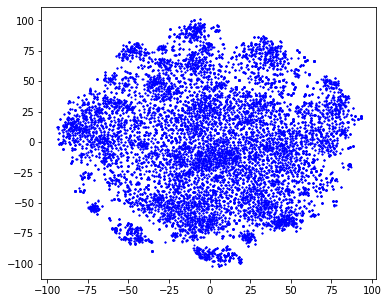

In [22]:
plt.figure(figsize=(6, 5))
plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1], s=1, c="blue")
plt.show()

In [23]:
from mysql.connector import (connection)
from Candidate_Generation import retrieve_candidates
from Database_Settings import DB_SETTINGS
import Database_connector
import pandas as pd

cnx = connection.MySQLConnection(**DB_SETTINGS)

#db_connection = Database_connector.Db_Connection()
def retrieve_db_df(query, cnx):
    cursor = cnx.cursor(dictionary=True)
    cursor.execute(query)
    results = cursor.fetchall()
    retrieved_df = pd.DataFrame([list(order_dict.values()) for order_dict in results], columns=list(results[0].keys()))
    return retrieved_df

LOAD_TAG_DATA = True
PKL_SAVE_PATH = "Pickled_Data/outfits_with_tags_tsne.pkl"

if not LOAD_TAG_DATA:
    # cursor = cnx.cursor(dictionary=True)
    outfit_query = "SELECT * FROM OutfitTags WHERE 'meta.validto' >= '9999-01-01 00:00:00'"
    outfit_tag_df = retrieve_db_df(outfit_query, cnx)

    tag_query = "SELECT * FROM Tags WHERE 'meta.validto' >= '9999-01-01 00:00:00'"
    tag_df = retrieve_db_df(tag_query, cnx)

    outfit_query = "SELECT id, owner, name FROM Outfits WHERE 'meta.validto' >= '9999-01-01 00:00:00'"
    outfit_df = retrieve_db_df(outfit_query, cnx)
    def group_outfit_tags_by_category(tag_df, outfit_tag_df, outfit_id):
        outfit_tags = tag_df[tag_df["id"].isin(outfit_tag_df[outfit_tag_df["outfitsId"] == outfit_id]["tagsId"])]
        tags_by_category = {}
        for row in outfit_tags.iterrows():
            if row[1]["tagCategory"] not in tags_by_category:
                tags_by_category[row[1]["tagCategory"]] = []
            tags_by_category[row[1]["tagCategory"]].append(row[1]["tag"])
        return tags_by_category

    outfit_df["outfit_tags"] = outfit_df["id"].apply(lambda x: group_outfit_tags_by_category(tag_df, outfit_tag_df, x))

    outfit_df.to_pickle(PKL_SAVE_PATH)
else:
    outfit_df = pd.read_pickle(PKL_SAVE_PATH)

outfit_df.head()

,id,owner,name,outfit_tags
0,outfit.00004b4d01ca4ab0a70cf073ba74fefa,user.66d3a17f5dd149f1845bbaf223c67cc3,Yugen Black Cardigan,"{'Material': ['Wool'], 'No category': ['Winter..."
1,outfit.00004b4d01ca4ab0a70cf073ba74fefa,user.66d3a17f5dd149f1845bbaf223c67cc3,Yugen Black Cardigan,"{'Material': ['Wool'], 'No category': ['Winter..."
2,outfit.001bf665330140cf854dcfb1cbff6b5f,user.91fee3d03276efed,Harley Vintage White Midi Dress,"{'Occassion': ['Going out', 'Wedding'], 'Waist..."
3,outfit.001bf665330140cf854dcfb1cbff6b5f,user.91fee3d03276efed,Out of stock - Harley Vintage White Midi Dress,"{'Occassion': ['Going out', 'Wedding'], 'Waist..."
4,outfit.001bf665330140cf854dcfb1cbff6b5f,user.91fee3d03276efed,Out of stock - Harley Vintage White Midi Dress,"{'Occassion': ['Going out', 'Wedding'], 'Waist..."


In [24]:
embeddings_df["tsne_embeds"] = tsne_embeds.tolist()
embeddings_df.rename(columns={"id": "picture_id"}, inplace=True)
outfit_tags = outfit_df[["id", "outfit_tags"]]
tsne_df = embeddings_df.merge(outfit_tags, left_on="owner", right_on="id", how="inner")
tsne_df.drop(columns=["id", "file_exists"], inplace=True)
tsne_df["category"] = tsne_df["outfit_tags"].apply(lambda x: x["Category"][0] if "Category" in x.keys() else "None")
tsne_df["color"] = tsne_df["outfit_tags"].apply(lambda x: x["Color"][0] if "Color" in x.keys() else "None")
tsne_df["material"] = tsne_df["outfit_tags"].apply(lambda x: x["Material"][0] if "Material" in x.keys() else "None")
tsne_df["brand"] = tsne_df["outfit_tags"].apply(lambda x: x["Brand"][0] if "Brand" in x.keys() else "None")
tsne_df["pattern"] = tsne_df["outfit_tags"].apply(lambda x: x["Pattern"][0] if "Pattern" in x.keys() else "None")
tsne_df.head()

,picture_id,owner,embeddings,tsne_embeds,outfit_tags,category,color,material,brand,pattern
0,picture.00058abb53434872ae9bb4270ae21f8e,outfit.98f32aaf08bc4ff09c44e6e11e9199bc,"[tensor(-0.3870, dtype=torch.float16), tensor(...","[5.798272132873535, 48.545833587646484]","{'Occassion': ['Going out', 'Everyday'], 'Wais...",Dresses,White,Cotton,FWSS,None
1,picture.00058abb53434872ae9bb4270ae21f8e,outfit.98f32aaf08bc4ff09c44e6e11e9199bc,"[tensor(-0.3870, dtype=torch.float16), tensor(...","[5.798272132873535, 48.545833587646484]","{'Occassion': ['Going out', 'Everyday'], 'Wais...",Dresses,White,Cotton,FWSS,None
2,picture.00058abb53434872ae9bb4270ae21f8e,outfit.98f32aaf08bc4ff09c44e6e11e9199bc,"[tensor(-0.3870, dtype=torch.float16), tensor(...","[5.798272132873535, 48.545833587646484]","{'Occassion': ['Going out', 'Everyday'], 'Wais...",Dresses,White,Cotton,FWSS,None
3,picture.00058abb53434872ae9bb4270ae21f8e,outfit.98f32aaf08bc4ff09c44e6e11e9199bc,"[tensor(-0.3870, dtype=torch.float16), tensor(...","[5.798272132873535, 48.545833587646484]","{'Occassion': ['Going out', 'Everyday'], 'Wais...",Dresses,White,Cotton,FWSS,None
4,picture.00058abb53434872ae9bb4270ae21f8e,outfit.98f32aaf08bc4ff09c44e6e11e9199bc,"[tensor(-0.3870, dtype=torch.float16), tensor(...","[5.798272132873535, 48.545833587646484]","{'Occassion': ['Going out', 'Everyday'], 'Wais...",Dresses,White,Cotton,FWSS,None


In [27]:
#Material categories
category_list = tsne_df["material"].value_counts().keys()[:9].tolist()
category_list.remove("None")
category_list.append("Denim")

In [10]:
category_list = tsne_df["brand"].value_counts().keys()[:10].tolist()
category_list.remove("None")
category_list

['FWSS',
 'Samsøe & Samsøe',
 'byTiMo',
 'By Malene Birger',
 'Maud',
 'Holzweiler',
 'ILAG',
 'Urban Pioneers',
 'Holzweiler x FJONG']

In [25]:
category_list = tsne_df["category"].value_counts().keys()[:10].tolist()
category_list

['Dresses',
 'Knitwear',
 'Outerwear',
 'Tops',
 'Skirts',
 'Pants',
 'Blouses',
 'Shirts',
 'Blazers',
 'Sweaters']

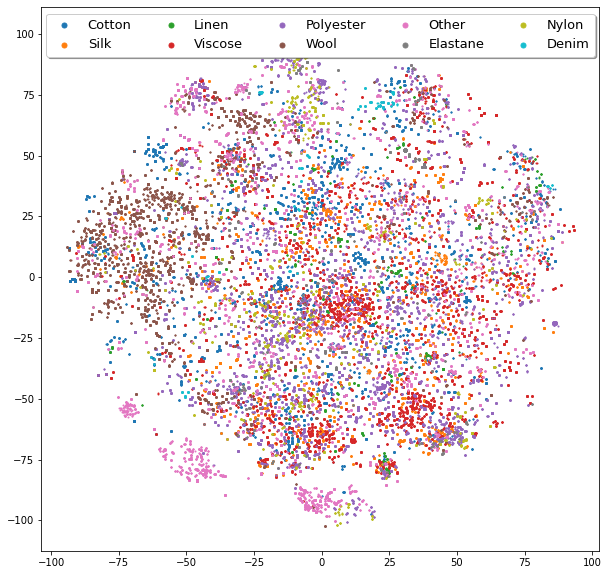

In [32]:
from matplotlib.pyplot import cm
import random

def plot_category(category_name, white_list=None):
    category_dict = {}
    for i, row in tsne_df.iterrows():
        if white_list:
            row_category = row[category_name] if row[category_name] in white_list else "Other"
        else:
            row_category = row[category_name]
        if row_category not in category_dict:
            category_dict[row_category] = []
        category_dict[row_category].append(np.array(row["tsne_embeds"]))

    for category in category_dict.keys():
        category_dict[category] = np.vstack(category_dict[category])

    color_pool = list(cm.rainbow(np.linspace(0, 1, len(category_dict.keys()))))
    random.shuffle(color_pool)
    color_pool = iter(color_pool)

    plt.figure(figsize=(10, 10))
    for category in category_dict.keys():
        tsne_x, tsne_y = category_dict[category][:, 0], category_dict[category][:, 1]
        cat_color = next(color_pool)
        plt.scatter(tsne_x, tsne_y, s=1, label=category)
        #plt.scatter(tsne_x, tsne_y, color=cat_color, s=1, label=category)

    #plt.legend(loc='upper center', fontsize="large", markerscale=5, bbox_to_anchor=(0.5, 1.10), ncol=6, fancybox=True, shadow=True)
    plt.legend(loc='upper center', fontsize=13, markerscale=5, bbox_to_anchor=(0.5, 1), ncol=5, fancybox=True, shadow=True)
    plt.show()

#plot_category("brand", category_list)
#plot_category("category", category_list)
plot_category("material", category_list)